# Проект: классификация

In [1432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [1433]:
df = pd.read_csv('Data/bank_fin.csv', sep = ';')

In [1434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [1435]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [1436]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace(" ", "").replace("$", "").replace(",", ".")).astype(float)
# вычислим среднее значение:
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [1437]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance']=df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [1438]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job']=df['job'].replace('unknown', df['job'].mode()[0])
df['education']=df['education'].replace('unknown', df['education'].mode()[0])
round(df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean(),3)

1598.883

### Задание 6

In [1439]:
# удалите все выбросы для признака balance

# метод Тьюки
quartile_1, quartile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
print(lower_bound,upper_bound)

outliers = df[(df['balance']<lower_bound) | (df['balance'] > upper_bound)]
df = df[(df['balance']>=lower_bound) & (df['balance'] <= upper_bound)]

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [1440]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# Сколько клиентов открыли депозит?
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задания 2 и 3

In [1441]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


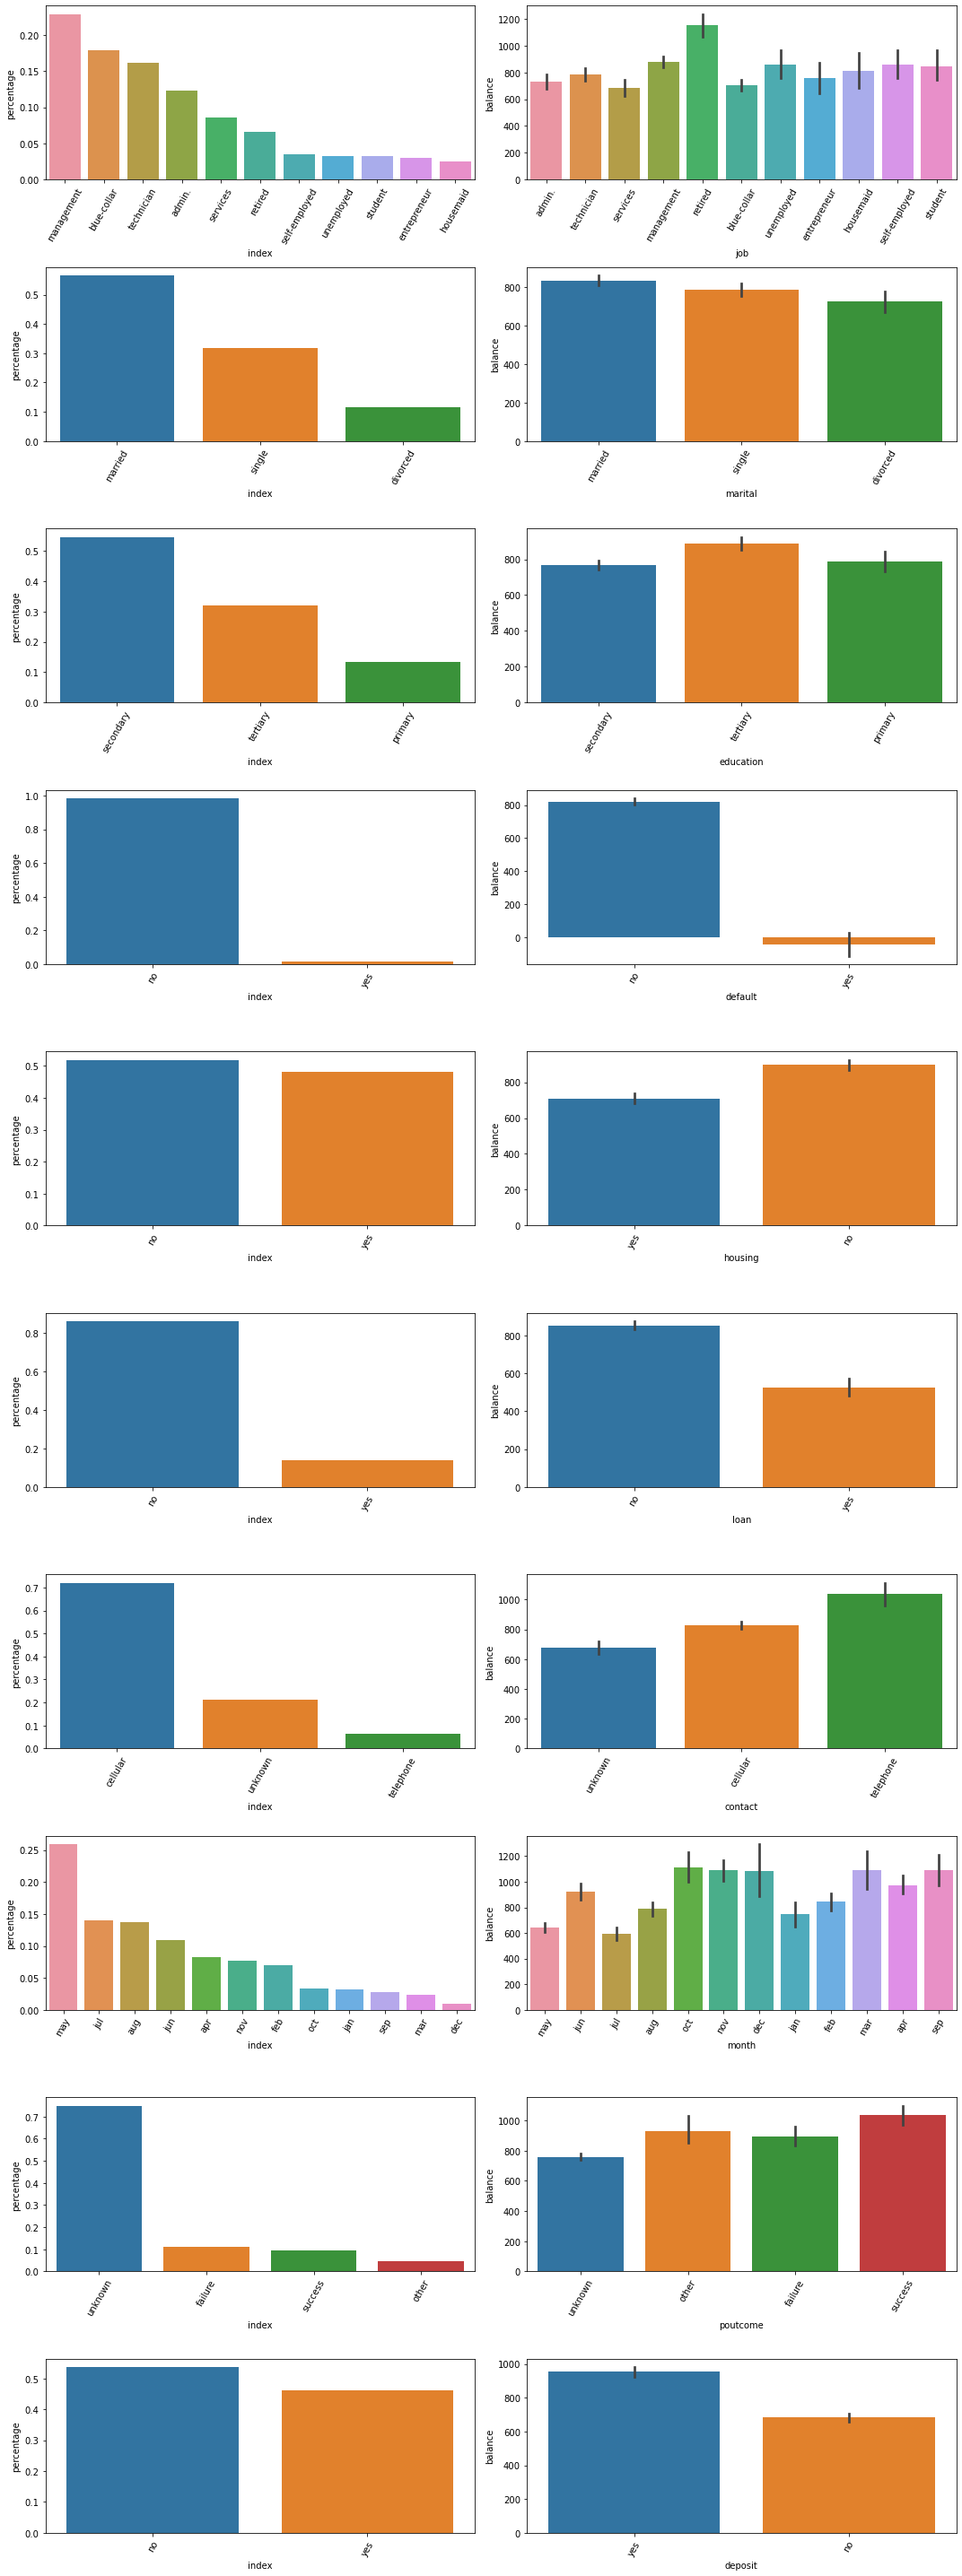

In [1442]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
display(df.describe(include = 'object'))

#постройте визуализации, иллюстрирующие результаты
types = df.dtypes
cat_features = list(types[(types == 'object')].index)

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='balance', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 6

In [1443]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
round(df.groupby('poutcome')['deposit'].value_counts(normalize=True)*100,0)

poutcome  deposit
failure   no         51.0
          yes        49.0
other     yes        55.0
          no         45.0
success   yes        91.0
          no          9.0
unknown   no         60.0
          yes        40.0
Name: deposit, dtype: float64

### Задание 7

In [1444]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
round(df.groupby('month')['deposit'].value_counts(normalize=True)*100,0)

month  deposit
apr    yes        62.0
       no         38.0
aug    no         56.0
       yes        44.0
dec    yes        90.0
       no         10.0
feb    yes        54.0
       no         46.0
jan    no         61.0
       yes        39.0
jul    no         59.0
       yes        41.0
jun    no         55.0
       yes        45.0
mar    yes        90.0
       no         10.0
may    no         68.0
       yes        32.0
nov    no         58.0
       yes        42.0
oct    yes        81.0
       no         19.0
sep    yes        83.0
       no         17.0
Name: deposit, dtype: float64

### Задание 8

age_group  deposit
30-40      no         57.0
           yes        43.0
40-50      no         61.0
           yes        39.0
50-60      no         59.0
           yes        41.0
60+        yes        76.0
           no         24.0
<30        yes        59.0
           no         41.0
Name: deposit, dtype: float64

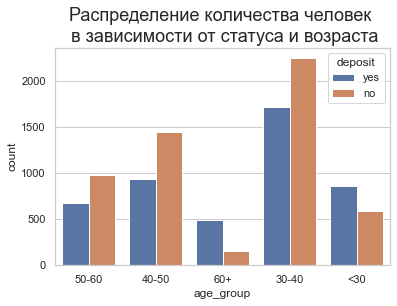

In [1532]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_group(age):
    if age<30: return '<30'
    if age<40: return '30-40'
    if age<50: return '40-50'
    if age<60: return '50-60'
    if age<30: return '<30'
    else: return '60+'
    
df['age_group'] = df['age'].apply(age_group)
display(round(df.groupby('age_group')['deposit'].value_counts(normalize=True)*100,0))

# визуализация
countplot = sns.countplot(data=df, x="age_group", hue="deposit");
countplot.set_title('Распределение количества человек \n в зависимости от статуса и возраста', fontsize=18);

### Задания 9 и 10

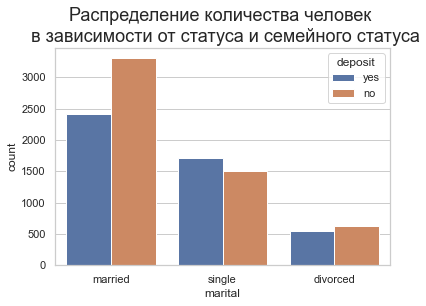

In [1531]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

countplot = sns.countplot(data=df, x="marital", hue="deposit");
countplot.set_title('Распределение количества человек \n в зависимости от статуса и семейного статуса', fontsize=18);

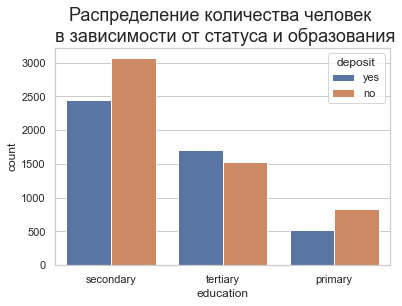

In [1530]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

countplot = sns.countplot(data=df, x="education", hue="deposit");
countplot.set_title('Распределение количества человек \n в зависимости от статуса и образования', fontsize=18);

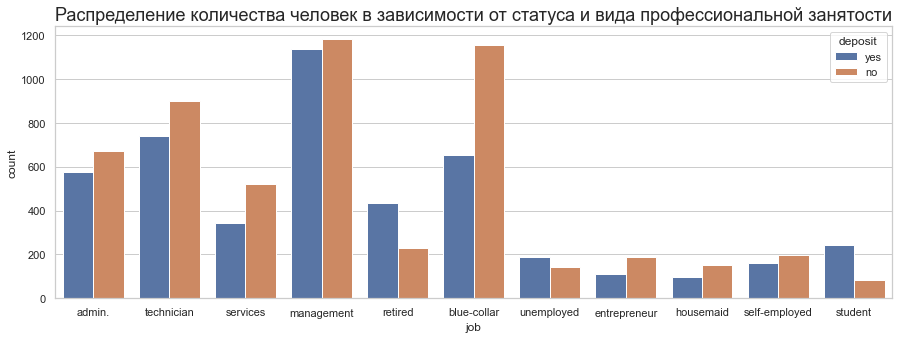

In [1528]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

fig = plt.figure(figsize=(15, 5))
countplot = sns.countplot(data=df, x="job", hue="deposit");countplot.set_title('Распределение количества человек в зависимости от статуса и вида профессиональной занятости', fontsize=18);


### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


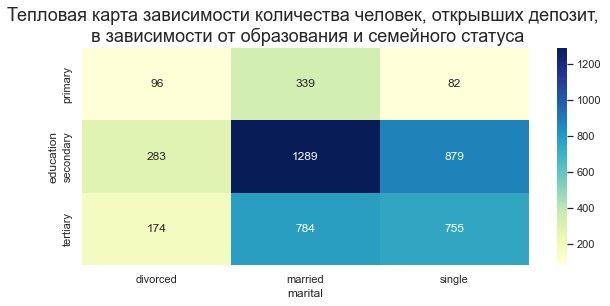

In [1547]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Строим сводную таблицу
df_pivot = df[df['deposit'] == 'yes'].pivot_table(
    values = 'deposit',
    index = 'education',
    columns = 'marital',
    aggfunc='count',
    )
display(df_pivot)


# Тепловая карта
fig = plt.figure(figsize=(10, 4))
heatmap = sns.heatmap(data=df_pivot, cmap='YlGnBu', annot=True, fmt="d")
heatmap.set_title('Тепловая карта зависимости количества человек, открывших депозит, \n в зависимости от образования и семейного статуса', fontsize=18);

## Часть 3: преобразование данных

### Задание 1

In [1450]:
# преобразуйте уровни образования

### Задания 2 и 3

In [1451]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [1452]:
# создайте дамми-переменные

### Задания 5 и 6

In [1453]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [1454]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [1455]:
# рассчитайте необходимые показатели

### Задание 9

In [1456]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [1457]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [1458]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [1459]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [1460]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [1461]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [1462]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [1463]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [1464]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [1465]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna